In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
import scipy.stats
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML
from brian2.units import *

from mpl_toolkits.axes_grid1 import make_axes_locatable



In [29]:

import matplotlib as mlib
from scipy import stats

mlib.rcParams.update({'font.size': 25})
mlib.rcParams.update({'errorbar.capsize': 5})

# Sigma stim vs sigma form lat

In [4]:
# I forgot to save p_elim_dep for each run. Extract it from file name
data = np.load("C:/Work/phd/simulation_statistics/batch_analysis_125544_03022018.npz")
metadata = np.load("C:/Work/phd/simulation_statistics/batch_13e10d3f268fa674c55c87e56084d78f.npz")
print data['recording_archive_name']
print 'Total time taken for simulations:', metadata['total_time']

../synaptogenesis/13e10d3f268fa674c55c87e56084d78f/case1_sstim3.5_sformlat3.5_run1_@13e10d3f268fa674c55c87e56084d78f.npz
Total time taken for simulations: 7:32:59.357172


In [5]:
snapshots = data['snapshots']
params = data['params']
dt = np.dtype([('rate', 'float'), 
               ('number_ff_synapses', 'float'), 
               ('final_weight_proportion', 'float'), 
               ('init_mean_std', 'float'),
               ('fin_mean_std_conn_shuf', 'float'),
               ('fin_mean_std_conn', 'float'),
               ('wsr_sigma_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_std_weight_shuf', 'float'),
               ('fin_mean_std_weight', 'float'),
               ('wsr_sigma_fin_weight_fin_weight_shuffle', 'float'),
               ('init_mean_AD', 'float'),
               ('fin_mean_AD_conn_shuf', 'float'),
               ('fin_mean_AD_conn', 'float'),
               ('wsr_AD_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_AD_weight_shuf', 'float'),
               ('fin_mean_AD_weight', 'float'),
               ('wsr_AD_fin_weight_fin_weight_shuffle', 'float'),
#                ('file_path', 'S59')
              ])
results = np.array(data['results'][:, :-1], dtype=dt)

In [6]:
parameters_of_interest = metadata['parameters_of_interest']

In [7]:
parameters_of_interest

array({'sigma_form_lats': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], 'no_runs': 1, 'cases': [1], 'sigma_stims': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]}, dtype=object)

In [8]:
all_names = np.asarray(results.dtype.names)
interesting_names = all_names[np.where(['init' not in name and 'wsr' not in name for name in all_names])]
interesting_names_indices = np.where(['init' not in name and 'wsr' not in name for name in all_names])[0]
print interesting_names
print interesting_names.shape
print [interesting_names[0]]
print results[interesting_names[0]].shape
print results['rate'].shape
print results['rate'].size

['rate' 'number_ff_synapses' 'final_weight_proportion'
 'fin_mean_std_conn_shuf' 'fin_mean_std_conn' 'fin_mean_std_weight_shuf'
 'fin_mean_std_weight' 'fin_mean_AD_conn_shuf' 'fin_mean_AD_conn'
 'fin_mean_AD_weight_shuf' 'fin_mean_AD_weight']
(11L,)
['rate']
(49L, 17L)
(49L, 17L)
833


In [9]:
del parameters_of_interest.ravel()[0]['no_runs']

In [10]:
parameters_of_interest.ravel()[0]['sigma_form_laterals'] = parameters_of_interest.ravel()[0].pop('sigma_form_lats')

In [11]:
params_of_interest = parameters_of_interest.ravel()[0].keys()
set_of_poi = np.ones((results.shape[0], len(params_of_interest))) * np.nan
for index, param_set in np.ndenumerate(params[:,0]):
    for poi in range(len(params_of_interest)):
        set_of_poi[index[0], poi] = param_set[params_of_interest[poi][:-1]]

In [12]:
results_with_poi = np.concatenate((np.asarray(results[:, interesting_names_indices], dtype=float), set_of_poi), axis=1)

In [13]:
parameters_of_interest

array({'cases': [1], 'sigma_form_laterals': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], 'sigma_stims': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]}, dtype=object)

In [14]:
sigma_stims = parameters_of_interest.ravel()[0]['sigma_stims']
sigma_form_laterals = parameters_of_interest.ravel()[0]['sigma_form_laterals']
hardcoded_t_record = 300 * second

print sigma_stims
print sigma_form_laterals
print params_of_interest

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
['cases', 'sigma_form_laterals', 'sigma_stims']


In [38]:
rates_all_results = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan
weight_prop = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan

std_weight_all_results = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan
ad_weight_all_results = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan

std_conn_all_results = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan
ad_conn_all_results = np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan

no_ff_conns= np.ones((len(sigma_stims), len(sigma_form_laterals))) * np.nan


CASE_1 = 1
for index, _ in np.ndenumerate(std_weight_all_results):
    sigma_index, sform_index = index
    logical_filter = np.logical_and(
                        np.logical_and(results_with_poi[:,-3]==CASE_1, results_with_poi[:, -1]==sigma_stims[sigma_index]),
                        results_with_poi[:,-2]==sigma_form_laterals[sform_index])
    std_weight_all_results[index] = results_with_poi[logical_filter].ravel()[6]
    ad_weight_all_results[index] = results_with_poi[logical_filter].ravel()[10]
    # use different set of results
    std_conn_all_results[index] =results_with_poi[logical_filter].ravel()[4]
    ad_conn_all_results[index] = results_with_poi[logical_filter].ravel()[8]
    
    rates_all_results[index] = results_with_poi[logical_filter].ravel()[0]
    weight_prop[index] = results_with_poi[logical_filter].ravel()[2]
    
    no_ff_conns[index] = results_with_poi[logical_filter].ravel()[1]
    



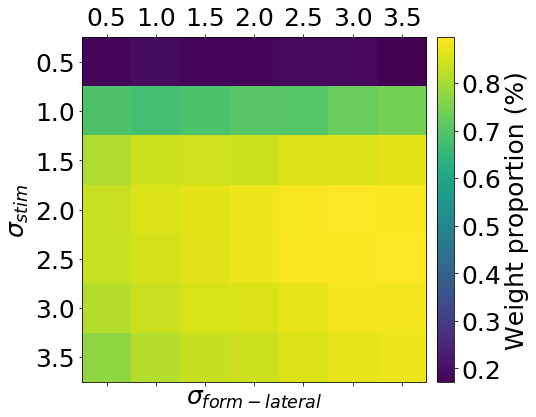

In [39]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(weight_prop)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Weight proportion (%)")
plt.tight_layout()
f.savefig('weight_proportion_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

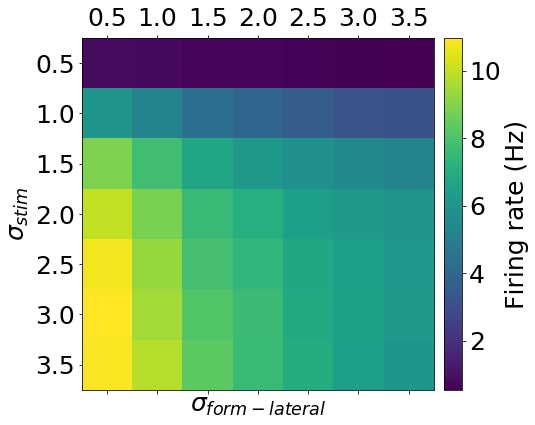

In [40]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(rates_all_results)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Firing rate (Hz)")
plt.tight_layout()
f.savefig('rates_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

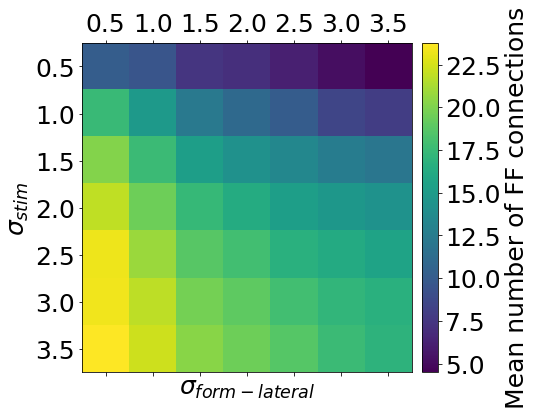

In [41]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(no_ff_conns)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Mean number of FF connections")
plt.tight_layout()
f.savefig('no_ff_conns_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

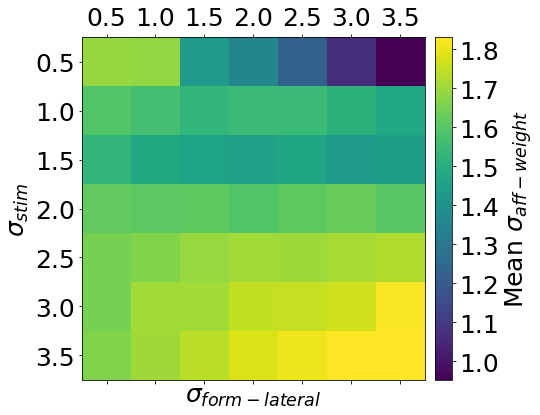

In [42]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(std_weight_all_results)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Mean $\sigma_{aff-weight}$")
plt.tight_layout()
f.savefig('std_weight_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

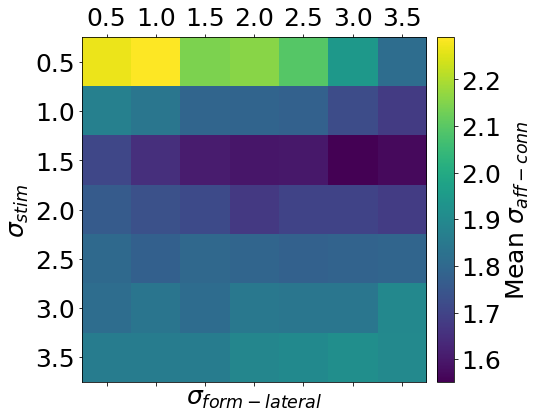

In [33]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(std_conn_all_results)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Mean $\sigma_{aff-conn}$")
plt.tight_layout()
f.savefig('std_conn_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

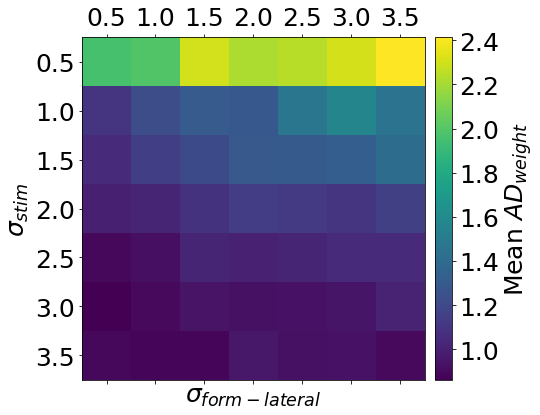

In [34]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(ad_weight_all_results)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Mean $AD_{weight}$")
plt.tight_layout()
f.savefig('ad_weight_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

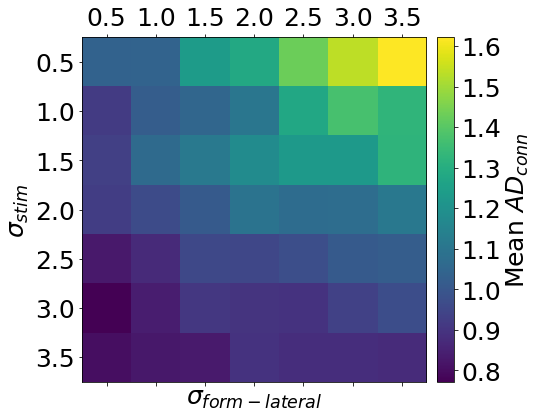

In [35]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8), dpi=800)
i = ax1.matshow(ad_conn_all_results)
ax1.grid(visible=False)
# ax1.set_title("Correlation matrix", fontsize=16)
ax1.set_ylabel("$\sigma_{stim}$")
ax1.set_xlabel("$\sigma_{form-lateral}$")
ax1.set_xticks(range(len(sigma_stims)))
ax1.set_xticklabels(sigma_stims, ha='center')
ax1.set_yticks(range(len(sigma_form_laterals)))
ax1.set_yticklabels(sigma_form_laterals, ha='right')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(i, cax=cax)
cbar.set_label("Mean $AD_{conn}$")
plt.tight_layout()
f.savefig('ad_conn_sigma_stim_vs_sigma_form_lat_LAT_INH.png')

# These details in numbers

In [44]:
from pprint import pprint as pp
print "rates_all_results \n", pp(rates_all_results)
print "weight_prop \n", pp(weight_prop )

print "std_weight_all_results \n", pp(std_weight_all_results) 
print "ad_weight_all_results \n", pp(ad_weight_all_results) 

print "std_conn_all_results \n", pp(std_conn_all_results) 
print "ad_conn_all_results \n", pp(ad_conn_all_results)

print "no_ff_conns \n", pp(no_ff_conns)


rates_all_results 
array([[  0.85246094,   0.81490885,   0.7228125 ,   0.6863151 ,
          0.63476562,   0.59050781,   0.53847656],
       [  5.9797526 ,   5.22358073,   4.33088542,   3.96173177,
          3.62933594,   3.22841146,   3.12139323],
       [  8.89981771,   7.78861979,   6.71778646,   6.19195313,
          5.80552083,   5.5003125 ,   5.21160156],
       [ 10.00515625,   8.85796875,   7.57964844,   7.08110677,
          6.44502604,   6.17940104,   5.93035156],
       [ 10.78282552,   9.34092448,   7.90880208,   7.39924479,
          6.75811198,   6.42893229,   6.12023437],
       [ 10.97317708,   9.53820313,   8.15546875,   7.63571615,
          6.92875   ,   6.47230469,   6.17683594],
       [ 10.91786458,   9.8125651 ,   8.34134115,   7.56505208,
          6.98666667,   6.42457031,   6.03083333]])
None
weight_prop 
array([[ 0.18472902,  0.19496209,  0.18034671,  0.18263488,  0.18899216,
         0.18915191,  0.17179106],
       [ 0.69387733,  0.68043109,  0.68994683,  0

In [48]:
np.unravel_index(std_weight_all_results.argmin(), std_weight_all_results.shape)

(0, 6)

In [49]:
np.unravel_index(ad_weight_all_results.argmin(), ad_weight_all_results.shape)

(5, 0)

In [50]:
np.unravel_index(std_weight_all_results.argmax(), std_weight_all_results.shape)

(6, 5)

In [51]:
np.unravel_index(ad_weight_all_results.argmax(), ad_weight_all_results.shape)

(0, 6)